# Лабораторна робота 4
## Аналіз та математичне моделювання COVID-19 за моделлю SIR

In [43]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy.integrate import odeint
from scipy.optimize import least_squares, differential_evolution
import matplotlib.pyplot as plt
import covsirphy as cs

In [44]:
CONFIRMED_CSV = "./time_series_covid_19_confirmed.csv"
DEATHS_CSV = "./time_series_covid_19_deaths.csv"
RECOVERED_CSV = "./time_series_covid_19_recovered.csv"

df_c = pd.read_csv(CONFIRMED_CSV)
df_d = pd.read_csv(DEATHS_CSV)
df_r = pd.read_csv(RECOVERED_CSV)

### 1. Функція агрегації

In [45]:
def aggregate_country(df, country):
    sub = df[df['Country/Region'] == country]
    grouped = sub.groupby('Country/Region').sum(numeric_only=True)
    date_cols = [
        col for col in grouped.columns
        if '/' in col  
    ]
    times = grouped.loc[country, date_cols]
    times.index = pd.to_datetime(times.index, format="%m/%d/%y")
    times.name = country
    return times

### 2. Побудова часових рядів для обраної країни

In [ ]:
country = 'Ukraine' 
confirmed = aggregate_country(df_c, country)
deaths = aggregate_country(df_d, country)

recovered = aggregate_country(df_r, country)

active = confirmed - deaths - recovered

start_idx = (confirmed > 0).idxmax()
confirmed = confirmed[start_idx:]
deaths = deaths[start_idx:]
recovered = recovered[start_idx:]
active = active[start_idx:]

### 3. Швидкі індикатори: темп росту, ковзне середнє

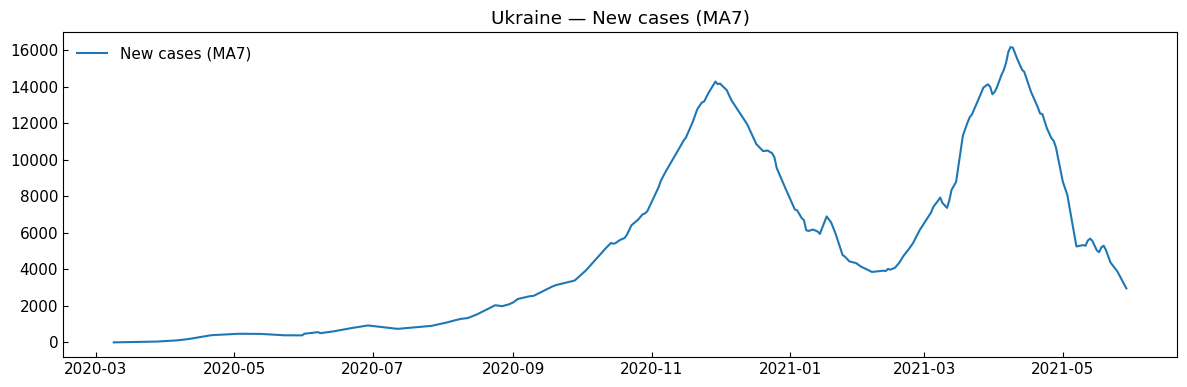

In [47]:
window = 7
new_cases = confirmed.diff().fillna(0)
new_cases_ma = new_cases.rolling(window).mean()


plt.figure(figsize=(12,4))
plt.plot(new_cases_ma, label='New cases (MA7)')
plt.title(country + ' — New cases (MA7)')
plt.legend()
plt.show()

### 4. Реалізація SIR-F та функції інтеграції

In [48]:
def sirf_ode(y, t, N, beta, gamma, mu):
    S, I, R, F = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - mu * I
    dRdt = gamma * I
    dFdt = mu * I
    return dSdt, dIdt, dRdt, dFdt


def run_sirf(t, y0, N, params):
    beta, gamma, mu = params
    ret = odeint(lambda y, t: sirf_ode(y, t, N, beta, gamma, mu), y0, t)
    return ret 

### 5. Підготовка даних 

In [49]:
I_data = active.values
R_data = recovered.values
F_data = deaths.values
observed_t = np.arange(len(I_data))

N = 4_100_0000

I0 = I_data[0] if I_data[0] > 0 else 1
R0 = R_data[0]
F0 = F_data[0]
S0 = N - I0 - R0 - F0

y0 = (S0, I0, R0, F0)

def residuals(params):
    beta, gamma, mu = params
    if any(p < 0 for p in params):
        return np.ones(len(observed_t)*3)*1e6
    sim = run_sirf(observed_t, y0, N, (beta, gamma, mu))
    S_sim, I_sim, R_sim, F_sim = sim.T

    res = np.concatenate([I_sim - I_data, R_sim - R_data, F_sim - F_data])
    return res

p0 = [0.3, 1/14, 0.01]

bounds = ([1e-6, 1/100, 0.0], [2.0, 1/2, 0.2])

### 6. Оцінка параметрів

In [50]:
print('Oптимізація...')
res = least_squares(residuals, p0, bounds=bounds, xtol=1e-8, ftol=1e-8)
beta_opt, gamma_opt, mu_opt = res.x
print('beta, gamma, mu =', res.x)

Oптимізація...
beta, gamma, mu = [0.61104127 0.5        0.08123251]


### 7. Прогноз ще на 300 днів

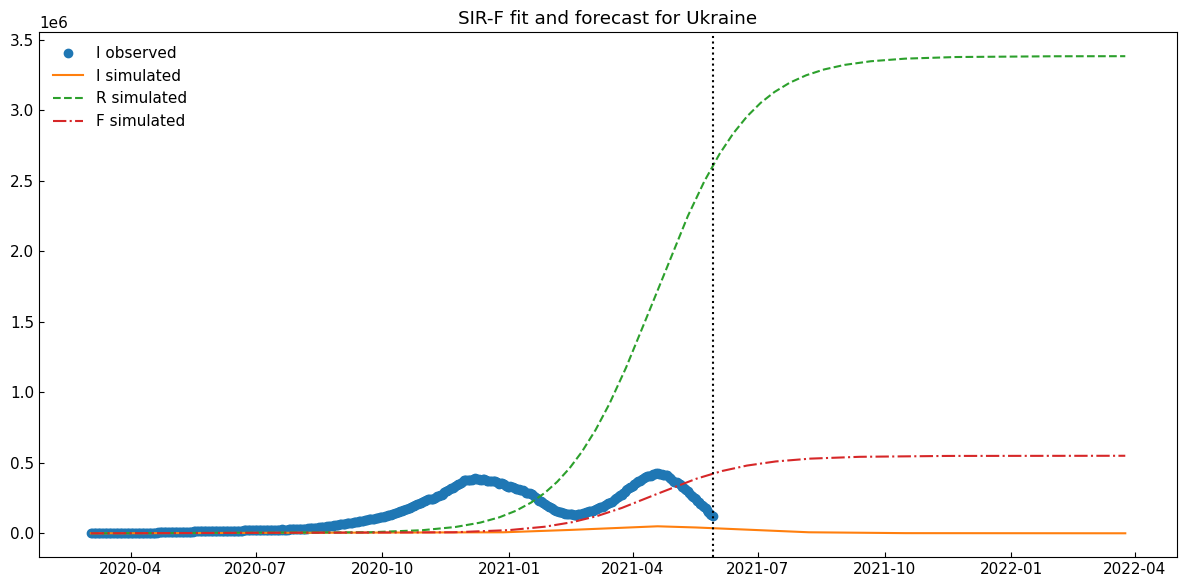

In [51]:
horizon = 300
t_all = np.arange(len(I_data) + horizon)
sim_all = run_sirf(t_all, y0, N, (beta_opt, gamma_opt, mu_opt))
S_sim, I_sim, R_sim, F_sim = sim_all.T

dates = pd.date_range(start=confirmed.index[0], periods=len(t_all))

plt.figure(figsize=(12,6))
plt.plot(dates[:len(I_data)], I_data, 'o', label='I observed')
plt.plot(dates, I_sim, '-', label='I simulated')
plt.plot(dates, R_sim, '--', label='R simulated')
plt.plot(dates, F_sim, '-.', label='F simulated')
plt.axvline(dates[len(I_data)-1], color='k', linestyle=':')
plt.legend()
plt.title(f'SIR-F fit and forecast for {country}')
plt.show()

### 8. Пікові дати та дата 'I < 1'

In [52]:
imax = np.argmax(I_sim)
peak_date = dates[imax]
print('Пік інфекції:', peak_date.date())

future_idx = np.where(I_sim[len(I_data):] < 1)[0]
if future_idx.size > 0:
    zero_date = dates[len(I_data) + future_idx[0]]
    print('Очікувана дата коли I < 1:', zero_date.date())
else:
    print('I не опуститься нижче 1 у прогнозованому горизонті')

Пік інфекції: 2021-04-17
I не опуститься нижче 1 у прогнозованому горизонті


### 9. Прогнози на 7,30,300 днів по Infected, Fatal, Recovered

In [53]:
for days in [7, 30, 300]:
    idx = len(I_data) - 1 + days
    print(f'Прогноз на +{days} днів: I={I_sim[idx]:.0f}, R={R_sim[idx]:.0f}, F={F_sim[idx]:.0f} (дата {dates[idx].date()})')

out = pd.DataFrame({'date': dates, 'S': S_sim, 'I': I_sim, 'R': R_sim, 'F': F_sim})
out.to_csv('sirf_simulation_output.csv', index=False)

Прогноз на +7 днів: I=30936, R=2721248, F=442108 (дата 2021-06-05)
Прогноз на +30 днів: I=19358, R=3007876, F=488675 (дата 2021-06-28)
Прогноз на +300 днів: I=10, R=3384130, F=549803 (дата 2022-03-25)
